# Data generation

In [ ]:
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
from generator import SkillsGenerator, DatasetGenerator
from tqdm.notebook import tqdm


%load_ext autoreload
%autoreload 2

In [5]:
## Loading the embedded taxonomy
emb_sh = "_jbEn"
with open(f"../../../data/taxonomy/taxonomy_embeddings{emb_sh}.pkl", "rb") as f:
    emb_tax = pickle.load(f)
    emb_tax["name"] = emb_tax["name+definition"].apply(
        lambda x : x.split(" : ")[0]
    )

## popularity measures
with open("frequency_vals.json", "r") as f:
    F = json.load(f)

## Loading the combination dist
combination_dist = np.loadtxt("assoc_skilled_dist.npy")

In [6]:
gen = SkillsGenerator(taxonomy=emb_tax, 
                taxonomy_is_embedded=True,
                combination_dist=combination_dist,
                popularity=F)

In [281]:
gen.label_to_idx

{'manage musical staff': 0,
 'supervise correctional procedures': 1,
 'apply anti-oppressive practices': 2,
 'control compliance of railway vehicles regulations': 3,
 'identify available services': 4,
 'perform toxicological studies': 5,
 'ensure coquille uniformity': 6,
 'Haskell': 7,
 'show initiative': 8,
 'train staff to reduce food waste': 9,
 'apply diplomatic principles': 10,
 'lead police investigations': 11,
 'handle fish harvesting waste': 12,
 'develop energy saving concepts': 13,
 'perform street interventions in social work': 14,
 'work with soloists': 15,
 'sport and exercise medicine': 16,
 'conduct research on flora': 17,
 'install heat pump': 18,
 'design biomass installations': 19,
 'handle equipment while suspended': 20,
 'teach housekeeping skills': 21,
 'check train engines': 22,
 'influence public policies': 23,
 'enterprise risk management': 24,
 'manufacture ingredients': 25,
 'maintain aquaculture ponds': 26,
 'apply credit risk policy': 27,
 'handle customer r

In [42]:
all_20NN_dist = -np.sort(-gen.pairwise_sims, axis=1)[::-1][:,:20]

(array([7.70000e+01, 6.88000e+02, 3.60000e+03, 1.96650e+04, 7.46820e+04,
        1.03994e+05, 4.46000e+04, 8.59100e+03, 5.23800e+03, 1.67850e+04]),
 array([0.6732285 , 0.70590574, 0.73858297, 0.77126014, 0.80393738,
        0.83661461, 0.86929184, 0.90196908, 0.93464625, 0.96732348,
        1.00000072]),
 <BarContainer object of 10 artists>)

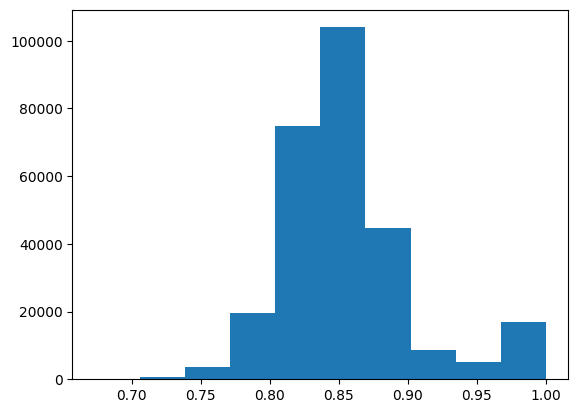

In [43]:
plt.hist(all_20NN_dist.flatten())

We'll have a threshold $T$ around $.80$, $.85$

In [32]:
T = 0.85
K = 20

sql_nns = gen.get_combination_for_('SQL', K, T)
train_nns = gen.get_combination_for_('check train engines', K, T)

In [36]:
for sql_nn in sql_nns:
    print("nn = ", sql_nn, ", pop = ", gen.popularity[sql_nn])

nn =  SQL , pop =  185.01495361328125
nn =  SPARQL , pop =  98.15958404541016
nn =  XQuery , pop =  320.8887023925781
nn =  LINQ , pop =  165.30068969726562
nn =  N1QL , pop =  296.7992858886719
nn =  MDX , pop =  255.05450439453125
nn =  LDAP , pop =  187.51942443847656
nn =  IBM Informix , pop =  447.3134460449219
nn =  query languages , pop =  248.62681579589844
nn =  Oracle Relational Database , pop =  321.0279846191406
nn =  Oracle Warehouse Builder , pop =  1422.4609375
nn =  DB2 , pop =  196.70513916015625
nn =  Pentaho Data Integration , pop =  792.0514526367188
nn =  Informatica PowerCenter , pop =  591.9312133789062
nn =  QlikView Expressor , pop =  790.2957153320312


In [206]:
gen.get_combination_for_("SQL", 50, 0.0, frequency_select=True)

['THC Hydra', 'Informatica PowerCenter']

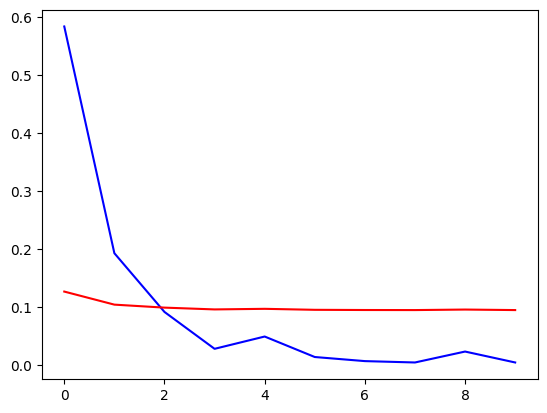

In [218]:
plt.plot(gen.combination_dist, color="blue")
soft_max = np.exp(gen.combination_dist/2) / np.exp(gen.combination_dist/2).sum()
plt.plot(soft_max, color="red")

In [226]:
nns = gen.get_combination_for_("SQL", 
                         k=50,
                         threshold=0.8,
                         frequency_select=False)

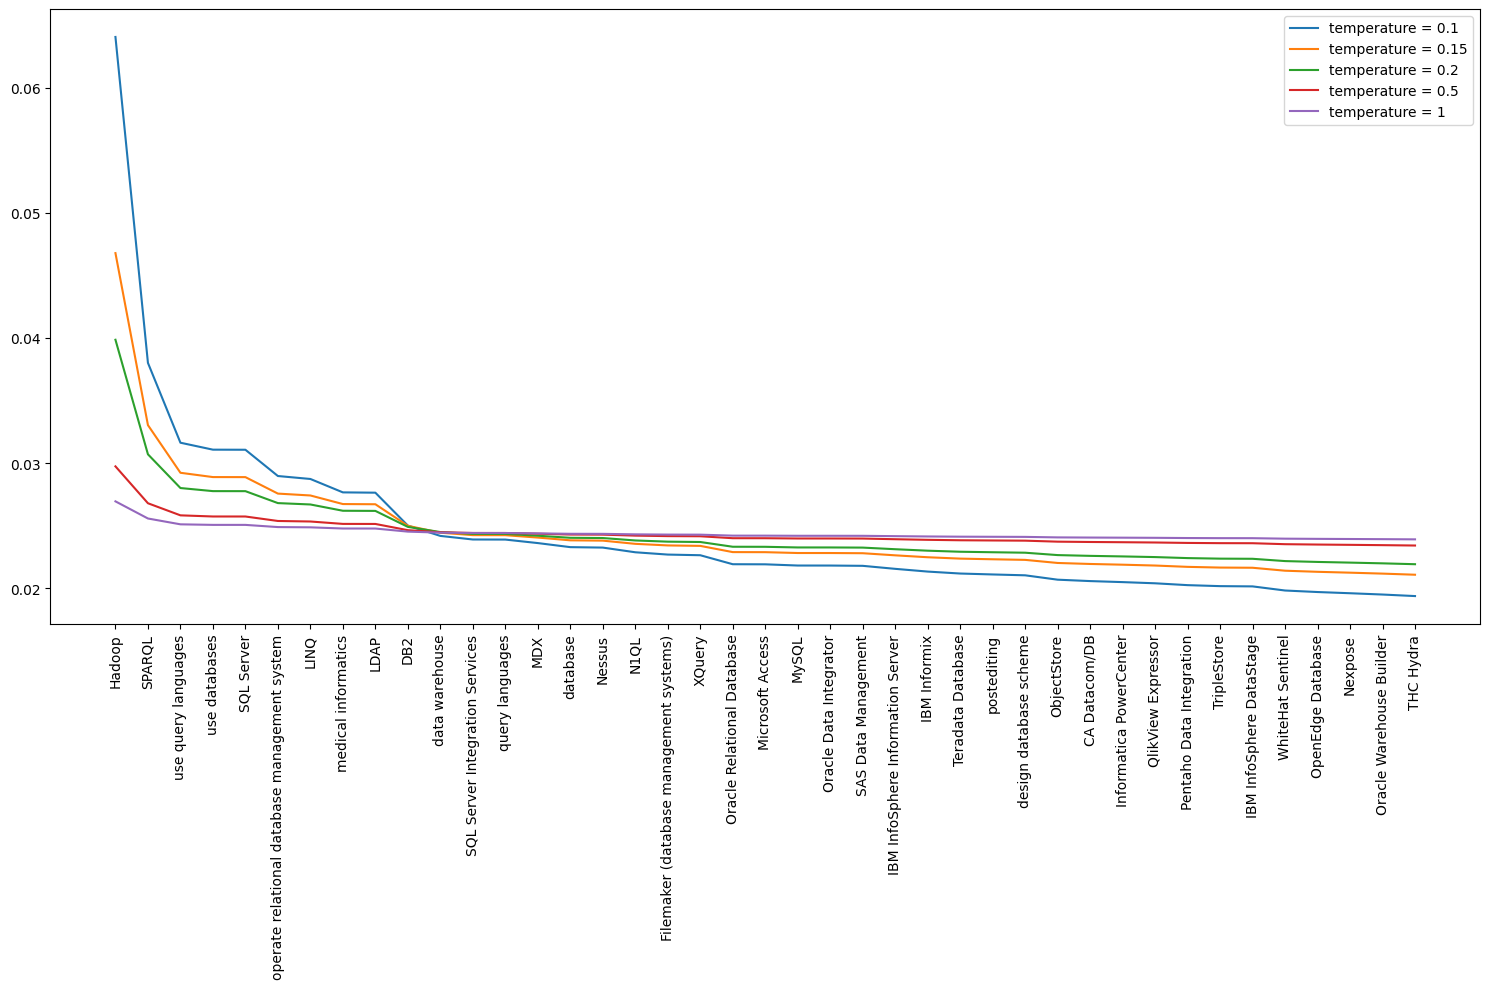

In [256]:
Ts = [0.1, 0.15, 0.2 ,0.5, 1]
f, a = plt.subplots(figsize=(15, 10))
F = np.array([gen.popularity[nn] for nn in nns])
xticklabels = [nns[i] for i in F.argsort()]
xticks = np.arange(len(xticklabels))
F_dist_base = np.sort(F / np.sum(F))[::-1]



for T in Ts:    
    F_dist = np.exp(F_dist_base / T) / np.sum(np.exp(F_dist_base / T))
    plt.plot(F_dist, label=f"temperature = {T}")

a.set_xticks(xticks)
a.set_xticklabels(xticklabels, rotation=90)
plt.legend()
plt.tight_layout()

In [265]:
bigF = np.array(list(gen.popularity.values()))
bigF = bigF / bigF.sum()

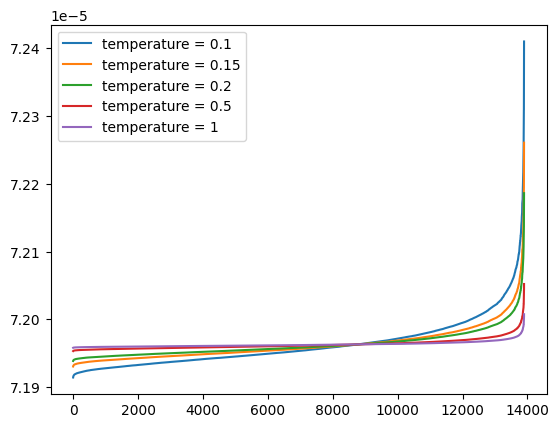

In [273]:
for T in Ts:
    sm_bigF = SkillsGenerator.softmax(bigF, T)
    plt.plot(np.sort(sm_bigF), label=f"temperature = {T}")
plt.legend()

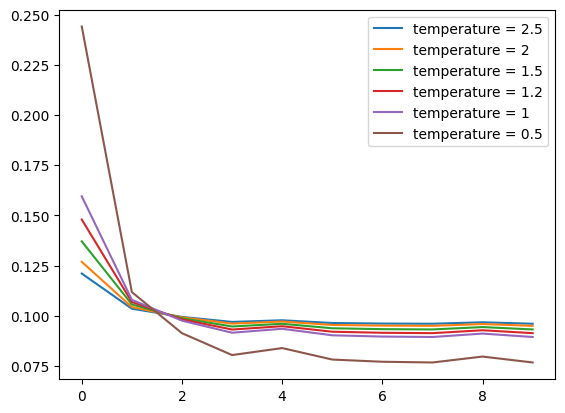

In [337]:
soften_comb_dist = gen.combination_dist
Ts = [2.5, 2, 1.5, 1.2, 1, 0.5]
for T in Ts:
    plt.plot(SkillsGenerator.softmax(soften_comb_dist, T), label=f"temperature = {T}")
plt.legend()

### Testing combination generator

In [377]:
stochastic_gen_args = {
    "total_generations" : 50, # number of samples
    "threshold" : 0.6, # not considering skills that are less than .8 similar
    "beam_size" : 20, # considering 20 skills
    "temperature_skill" : 1, # we want to see diversity in generated words
    "temperature_pairing": 0.5, # popularity to be skewed toward popular skills
    "temperature_sample_size": 0.9,
    "frequency_select": False, # wether we select within the NN acording to frequency
}

generations = gen.stochastic_inf_iter(**stochastic_gen_args)

In [378]:
combinations = []
for combin in generations:
    print(combin)
    combinations.append(combin)

['triage clients for physiotherapy', 'perform on-treatment review', 'provide advanced clinical practice in physiotherapy', 'maintain physiotherapy equipment', 'prescribe tests for physiotherapy']
['prevent fraudulent activities', 'security threats', 'recognise indicators of problem betting', 'detect financial crime', 'perform drug investigations', 'investigate complaints related to consumer protection', 'fraud detection', 'review criminal acts', 'practice vigilance']
['sell art']
['sales promotion techniques']
['ensure compliance with disclosure criteria of accounting information', 'create underwriting guidelines', 'identify key processes of traceability systems ', 'conduct content quality assurance', 'develop procurement strategy', 'develop investigation strategy', 'handle case evidence', 'ensure gambling operational standards']
['operate breathing equipment', 'operate heart-lung machines']
['manufacturing of wearing apparel', 'knitting machine technology', 'use textile finishing mach

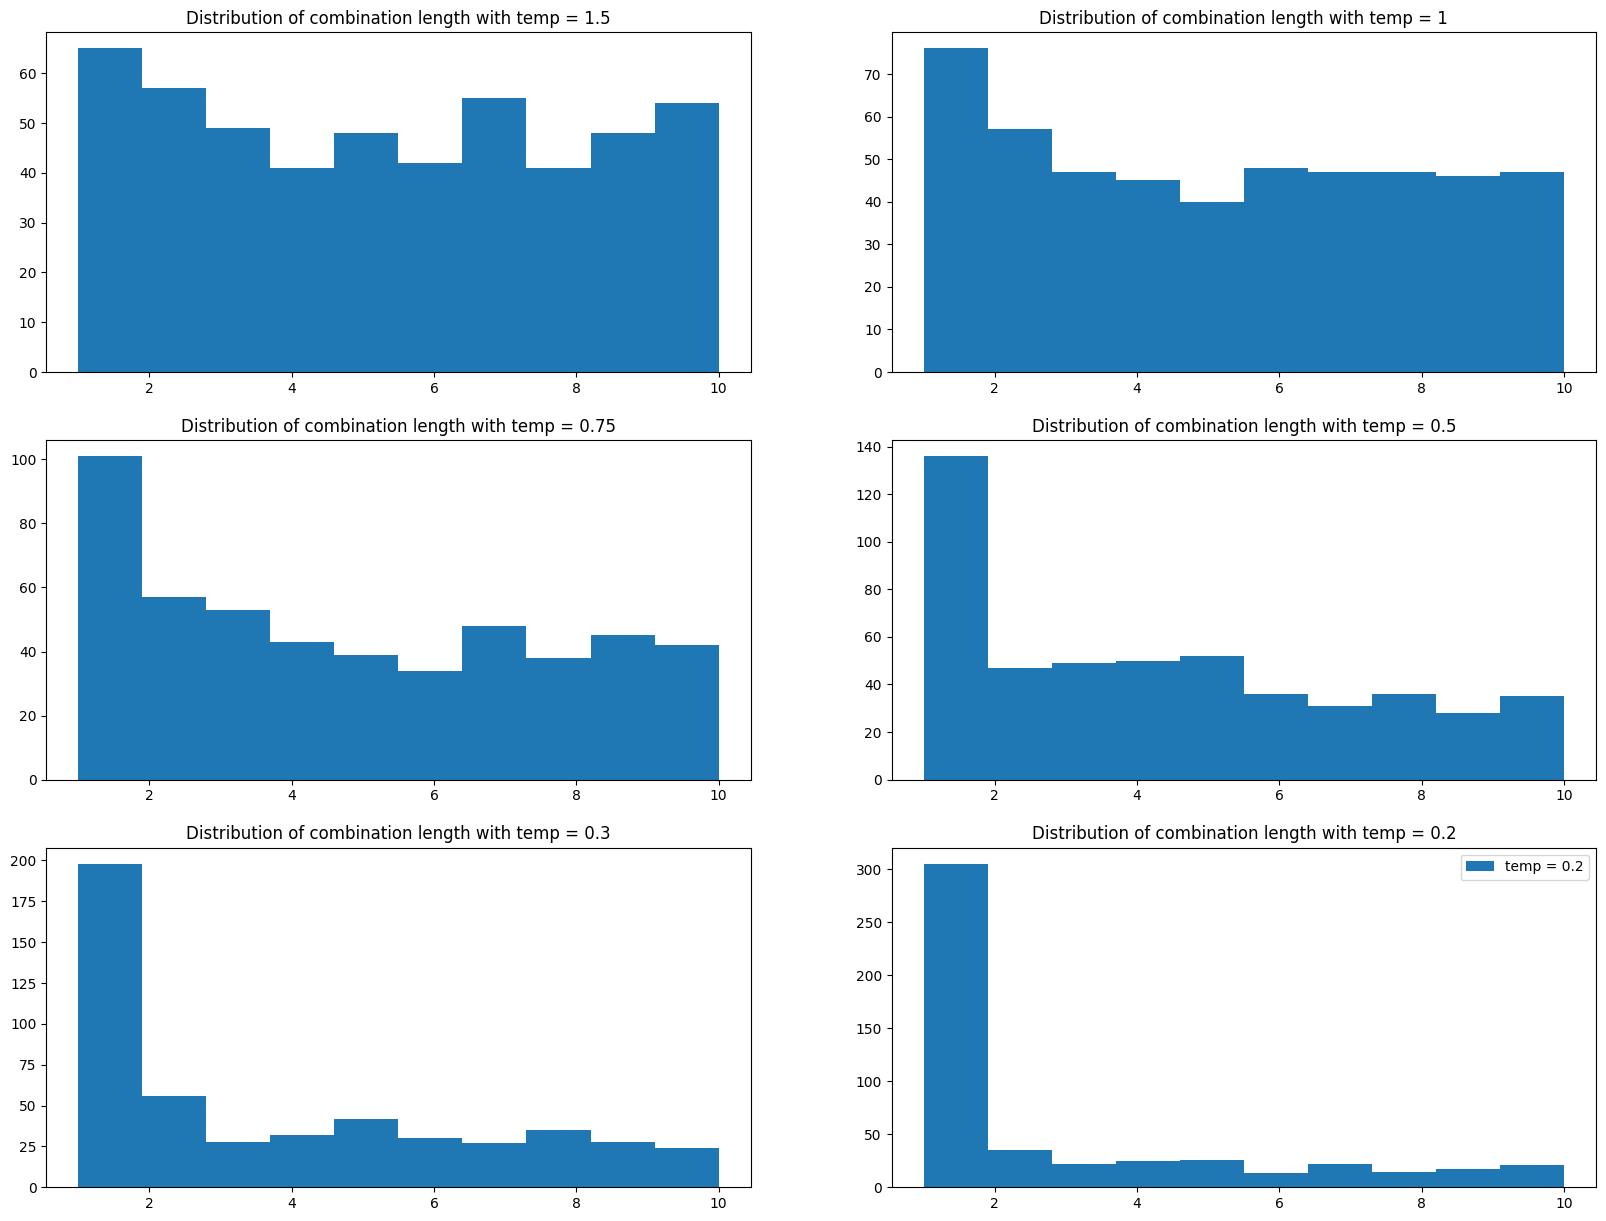

In [389]:
f, a = plt.subplots(3, 2, figsize=(20, 15))
Ts = [1.5, 1, 0.75, 0.5, 0.3, 0.2]
for ax, T in zip(a.flatten(), Ts):
    stochastic_gen_args = {
    "total_generations" : 500, # number of samples
    "threshold" : 0.6, # not considering skills that are less than .8 similar
    "beam_size" : 20, # considering 20 skills
    "temperature_skill" : 1, # we want to see diversity in generated words
    "temperature_pairing": 0.5, # popularity to be skewed toward popular skills
    "temperature_sample_size": T,
    "frequency_select": False, # wether we select within the NN acording to frequency
    }

    generations = gen.stochastic_inf_iter(**stochastic_gen_args)
    ax.hist([len(x) for x in generations], label=f"temp = {T}")
    ax.set_title(f"Distribution of combination length with temp = {T}")
plt.legend()

In [439]:
from itertools import product, combinations

Ts = [2, 1, 0.5, 0.2]
res_sim = {}
res_pop = {}
for ax, T in tqdm(zip(a.flatten(), Ts)):
    stochastic_gen_args = {
    "total_generations" : 500, # number of samples
    "threshold" : 0.6, # not considering skills that are less than .8 similar
    "beam_size" : 50, # considering 20 skills
    "temperature_skill" : 1, # we want to see diversity in generated words
    "temperature_pairing": T, # popularity to be skewed toward popular skills
    "temperature_sample_size": 0.5,
    "frequency_select": True, # wether we select within the NN acording to frequency
    }

    generations = gen.stochastic_inf_iter(**stochastic_gen_args)
    sims = []
    popularities = []
    for generation in  generations:
        intra_sim = []
        if(len(generation) > 1):
            s1 = generation[0]
            for s2 in generation[1:]:
                intra_sim.append(gen.pairwise_sims[gen.label_to_idx[s1], gen.label_to_idx[s2]])
                popularities.append(gen.popularity[s2])
            sims.append(sum(intra_sim) / len(intra_sim))
    res_sim[T] = sims
    res_pop[T] = popularities

0it [00:00, ?it/s]

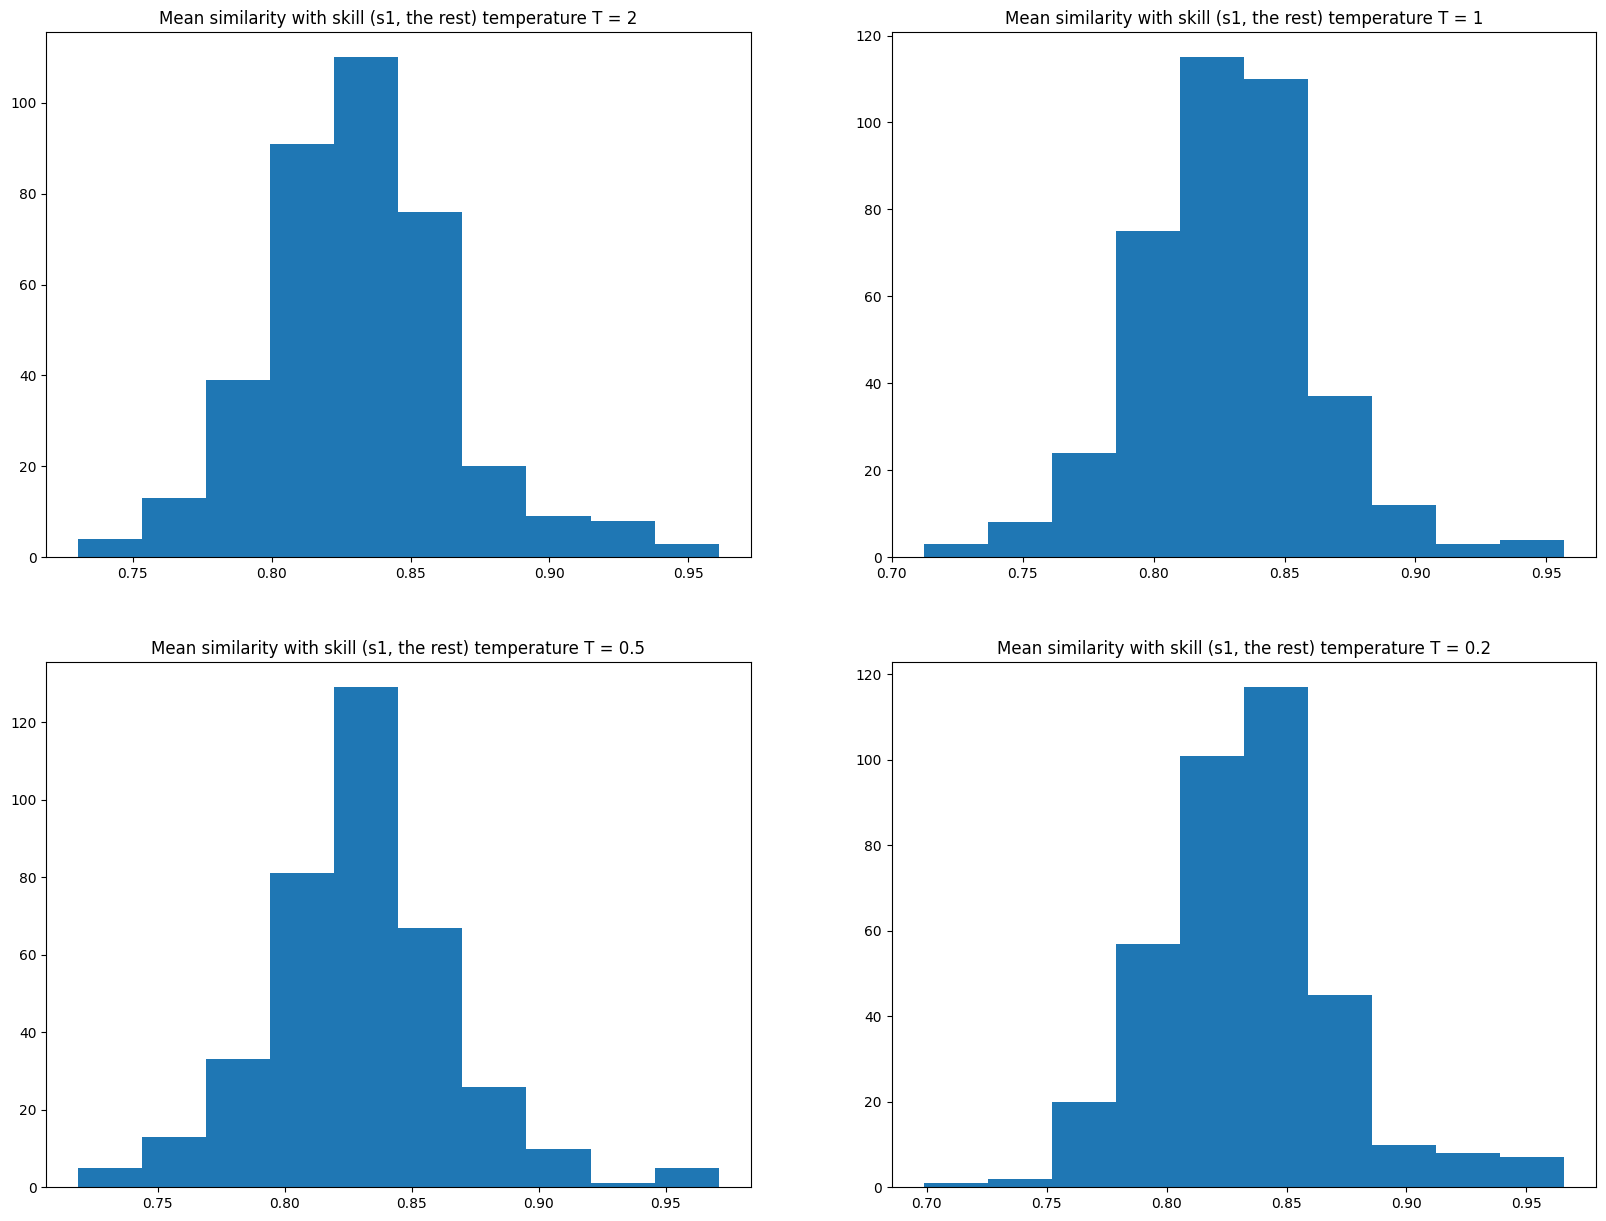

In [440]:
f, a = plt.subplots(2, 2, figsize=(20, 15))

for ax, (T, sims) in zip(a.flatten(), res_sim.items()):
    ax.hist(sims)
    ax.set_title(f"Mean similarity with skill (s1, the rest) temperature T = {T}")

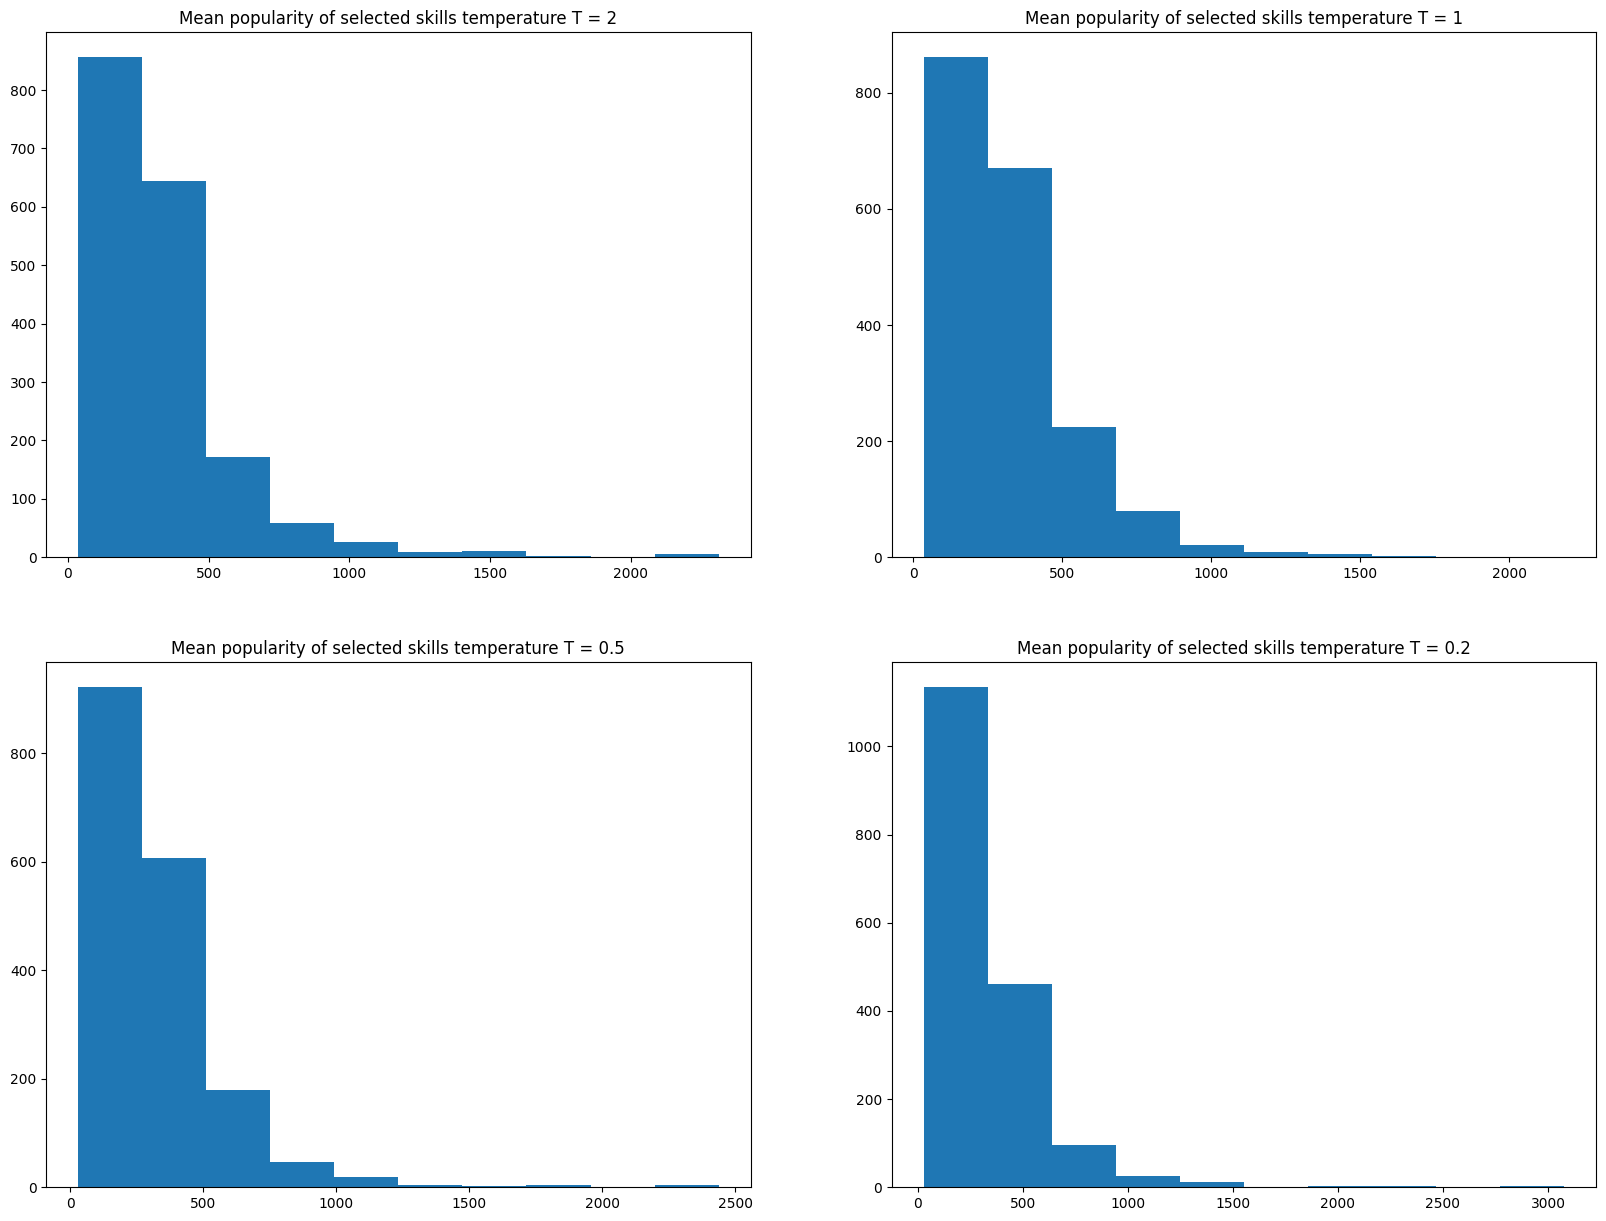

In [441]:
f, a = plt.subplots(2, 2, figsize=(20, 15))

for ax, (T, sims) in zip(a.flatten(), res_pop.items()):
    ax.hist(sims)
    ax.set_title(f"Popularities of selected skills temperature T = {T}")

### Studying potential redundancies

In [474]:
stochastic_gen_args = {
"total_generations" : 5000, # number of samples
"threshold" : 0.6, # not considering skills that are less than .8 similar
"beam_size" : 50, # considering 20 skills
"temperature_skill" : 1, # we want to see diversity in generated words
"temperature_pairing": 2, # popularity to be skewed toward popular skills
"temperature_sample_size": 0.2,
"frequency_select": True, # wether we select within the NN acording to frequency
}

generations = gen.stochastic_inf_iter(**stochastic_gen_args), 

In [475]:
from collections import Counter

all_words = []
all_gens = []
for generation in generations:
    for g in generation:
        all_gens.append(g)
        for u in g:
            all_words.append(u)

count_w = Counter(set(all_words))

(array([   0.,    0.,    0.,    0.,    0., 8173.,    0.,    0.,    0.,
           0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

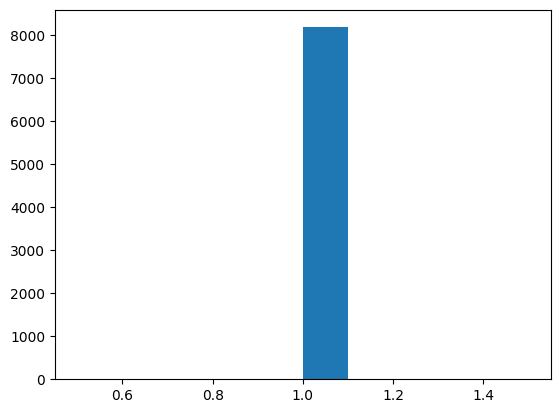

In [476]:
plt.hist(list(count_w.values()))

In [477]:
all_gens

[['research welding techniques',
  'install construction profiles',
  'methods of drying timber',
  'food colorants',
  'casting processes'],
 ['develop codified movements',
  'perform virtual simulation ',
  'test prosthetic-orthotic devices',
  'post-processing of photographs',
  'determine image composition',
  'post-process medical images',
  'edit recorded sound'],
 ["integrate headquarter's guidelines into local operations"],
 ['food and beverages on the menu'],
 ['make architectural mock-ups',
  'interpret 3D plans',
  'adjust the work during the creative process',
  'present artistic design proposals',
  'approve engineering design',
  'plan scaffolding',
  'create mood boards'],
 ['Backbox (penetration testing tool)'],
 ['prepare equipment for navigation operations'],
 ['assist physiotherapists',
  'provide chiropractic paediatric healthcare',
  'develop strategic plans for physiotherapy services',
  'provide osteopathic treatment to animals',
  'manage physiotherapy staff',
 

In [480]:
stochastic_gen_args = {
"total_generations" : 5000, # number of samples
"threshold" : 0.6, # not considering skills that are less than .8 similar
"beam_size" : 50, # considering 20 skills
"temperature_skill" : 1, # we want to see diversity in generated words
"temperature_pairing": 2, # popularity to be skewed toward popular skills
"temperature_sample_size": 0.15,
"frequency_select": True, # wether we select within the NN acording to frequency
}

generations = gen.stochastic_inf_iter(**stochastic_gen_args),


from collections import Counter

all_words = []
all_gens = []
for generation in generations:
    for g in generation:
        all_gens.append(g)
        for u in g:
            all_words.append(u)

count_w = Counter(set(all_words))

In [481]:
all_gens

[['cultivate plankton '],
 ['identify music with commercial potential', 'monitor artwork market'],
 ['notify supervisor'],
 ['operate paper bag machine'],
 ['make strategic business decisions'],
 ['operate wine pumps'],
 ['shift energy demands'],
 ['use functional programming'],
 ['make decisions'],
 ['moderate in negotiations'],
 ['diagnose heart conditions'],
 ['supervise legal case procedures'],
 ['conduct environmental surveys'],
 ['Sass'],
 ['implement ICT coding conventions'],
 ['online ads campaign techniques',
  'digital marketing techniques',
  'implement marketing strategies'],
 ['tend textile finishing machines'],
 ['apply GMP'],
 ['tend soap flake machinery',
  'types of lathe tools',
  'operate screen printing equipment for textiles',
  'repair wood board machinery',
  'operate metal heating equipment',
  'operate brazing equipment',
  'manipulate rubber products',
  'torch temperature for metal processes'],
 ['develop tourism products'],
 ['communicate in air traffic serv

## Simple generations

In [72]:
stochastic_gen_args = {
"total_generations" : 10, # number of samples
"threshold" : 0.6, # not considering skills that are less than .8 similar
"beam_size" : 50, # considering 20 skills
"temperature_skill" : 1, # we want to see diversity in generated words
"temperature_pairing": 2, # popularity to be skewed toward popular skills
"temperature_sample_size": 0.1,
"frequency_select": True, # wether we select within the NN acording to frequency
}

generations = gen.stochastic_inf_iter(**stochastic_gen_args)

In [73]:
datagen = DatasetGenerator(emb_tax)

In [32]:
res = datagen.generate_ds(generations, specific_few_shots=False)

0it [00:00, ?it/s]

In [34]:
for (skills, job_posting) in res:
    print("skills : ", skills)
    print("jobs posting : ", job_posting.replace("Job Opening:", ""))
    print("-"*100)

skills :  ['inspect construction of ships', 'inspect drainage channels', 'clean camping facilities', 'inspect fire equipment']
jobs posting :   Database Administrator

We are searching for an experienced Database Administrator to join our team. The ideal candidate must have a strong background in SQL and relational databases. As a Database Administrator, you will be responsible for managing and optimizing our company's databases.

Responsibilities:
- Design, implement, and maintain database systems.
- Monitor database performance and optimize queries for efficiency.
- Troubleshoot and resolve database issues and errors.
- Perform data backups and implement disaster recovery plans.
- Collaborate with development teams to ensure database design is optimized for performance.
- Develop and maintain database documentation, including data standards and procedures.
- Stay up-to-date with the latest database technologies and best practices.

Requirements:
- Bachelor's degree in Computer Scienc

### Specific few shots 

In [52]:
test = pd.read_csv("https://raw.githubusercontent.com/jensjorisdecorte/Skill-Extraction-benchmark/main/tech_test_annotations.csv")
test = test[~test.label.isin(["LABEL NOT PRESENT", "UNDERSPECIFIED"])]
multilabel = test.groupby("sentence").agg({"label": lambda x : x.tolist() , "span": lambda x : x.tolist()}).reset_index()
multilabel["skill+sentence"] = multilabel[["label", "sentence"]].apply(lambda x : str(x["label"]) + " : " + x["sentence"], axis=1)
multilabel.head(5)

,sentence,label,span,skill+sentence
0,( Cypress for frontend is a must have pytest f...,[Solidity],[Solidity],['Solidity'] : ( Cypress for frontend is a mus...
1,* Ability to analyse requirements and interact...,"[analyse business requirements, communicate wi...","[analyse requirements, interact directly with ...","['analyse business requirements', 'communicate..."
2,* Ability to support the developers in your te...,"[manage a team, lead others, mentor individual...","[support the developers in your team, leading,...","['manage a team', 'lead others', 'mentor indiv..."
3,* Ability to work in large collaborative teams...,"[work in teams, meet commitments, work in team...","[work in large collaborative teams, achieve or...","['work in teams', 'meet commitments', 'work in..."
4,* Ability to work in large collaborative teams...,"[work in teams, meet commitments, think innova...","[work in large collaborative teams, achieve or...","['work in teams', 'meet commitments', 'think i..."


In [101]:
from transformers import AutoModel, AutoTokenizer

stochastic_gen_args = {
"total_generations" : 10, # number of samples
"threshold" : 0.6, # not considering skills that are less than .8 similar
"beam_size" : 50, # considering 20 skills
"temperature_skill" : 1, # we want to see diversity in generated words
"temperature_pairing": 2, # popularity to be skewed toward popular skills
"temperature_sample_size": 0.1,
"frequency_select": True, # wether we select within the NN acording to frequency
"upper_bound_skill_matching": 0
}

generations = gen.stochastic_inf_iter(**stochastic_gen_args)

word_emb = "jjzha/jobbert-base-cased"
word_emb_model = AutoModel.from_pretrained(word_emb)
word_emb_tokenizer = AutoTokenizer.from_pretrained(word_emb)


datagen = DatasetGenerator(emb_tax,
                           multilabel,
                           word_emb_model,
                           word_emb_tokenizer)

Some weights of BertModel were not initialized from the model checkpoint at jjzha/jobbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
datagen.generate_specific_few_shots(["SQL", "python"], 5)

["skills: ['Agile project management']\nJob Opening : You have spent many years devoting yourself to software development and have experience working in an agile project team ..\n",
 "skills: ['PostgreSQL', 'PostgreSQL']\nJob Opening : django postgresql redis.\n",
 "skills: ['quality assurance procedures', 'Python (computer programming)', 'automation technology', 'quality assurance procedures', 'Python (computer programming)', 'automation technology']\nJob Opening : qa python automation.\n",
 "skills: ['listen actively']\nJob Opening : You're both a good listener and able to explain concepts to others ..\n",
 "skills: ['SQL']\nJob Opening : • SQL knowledge ..\n"]

In [102]:
res = datagen.generate_ds(generations, specific_few_shots=True, nb_few_shots=3)

0it [00:00, ?it/s]

----------------------------------------------------------------------------------------------------
You are a hiring manager for a big company. You need to define write a job opening for different skill requirements in your company.

You are a hiring manage for a big company and you work in collaboration with ESCO to gather rigid standards for job postings. Given a list of ESCO skills and knowledges, you're asked to provide 1 examples that could be found in a job ad and refer to the skill or knowledge compenents.. Ensure that your examples are well written and could be found in real job advertisement. At least 75% of the job postings you will write should not contain any reference to the skills themselves. With each skills you will get a description of what it actually consists.

skills: ['Agile development', 'develop new products']
Job Opening : Passion for agile software development product discovery and continuous deployment.
skills: ['JavaScript', 'Angular', 'TypeScript', 'JavaScr

⚠️ ⚠️ ⚠️ ⚠️ Issue : the shots are only tech related!!! ⚠️ ⚠️ ⚠️ ⚠️

In [103]:
for (skills, job_posting) in res:
    print("skills : ", skills)
    print("jobs posting : ", job_posting.replace("Job Opening:", ""))
    print("-"*100)

skills :  ['graphics editor software']
jobs posting :   We are looking for a highly motivated and self-driven individual to join our team as a Product Development Associate. The ideal candidate will possess strong problem-solving skills, be able to work independently, and have a passion for developing innovative products. The role will involve collaborating with cross-functional teams to design and develop new products that meet the needs of our customers.
----------------------------------------------------------------------------------------------------
skills :  ['set up documentation control system']
jobs posting :  Job Opening : Ensure the highest level of quality in all aspects of software development through thorough testing and quality assurance processes.
----------------------------------------------------------------------------------------------------
skills :  ['treat medical conditions of elderly people']
jobs posting :   We are seeking a skilled Software Test Automation 